In [2]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import time
import pickle as pkl
from sklearn.metrics import confusion_matrix

In [3]:
# methods for extracting and processing data

def get_data(filename):
    """Get datasets from h5 file

    Args:
        filename (string): relative path to the .h5 file
        
    Returns:

    """
    with h5py.File(filename, 'r') as f:
        train_data = np.array(f['trX'])
        train_labels = np.array(f['trY'])
        test_data = np.array(f['tstX'])
        test_labels = np.array(f['tstY'])
    
    return train_data, train_labels, test_data, test_labels

def bias_extension_X(data):
    """Add bias to data

    Args:
        data (ndarray): data to be extended with bias, shape (D_x, m, T_x)

    Returns:
        data : data extended with bias, shape (D_x + 1, m, T_x)
    """
    data = np.concatenate( ( data, np.ones((1, data.shape[1], data.shape[2]))), axis=0)  
    return data

def normalize(data):
    """Normalize data by mean and std

    Args:
        data (ndarray): data to be normalized, shape (D_x, m, T_x)

    Returns:
        data : data normalized by mean and std, shape (D_x, m, T_x)
    """
    data = (data - np.mean(data, axis=0, keepdims=True)) / np.std(data, axis=0, keepdims=True)
    return data

def bias_extension_A(A):
    """Add bias to A

    Args:
        A (ndarray): A to be extended with bias, shape (D_h, D_h)

    Returns:
        A : A extended with bias, shape (D_h + 1, D_h)
    """
    A = np.concatenate((A, np.zeros((1, A.shape[1])),), axis=0)
    return A

In [4]:
# extract data from h5 file
train_data, train_labels, test_data, test_labels = get_data('data-Mini Project 2.h5')

print(train_data.shape)
print(train_data[0, 0, :])
print(train_labels.shape)
print(train_labels[0]) # already one-hot encoded

train_data = np.transpose(train_data, (2, 0, 1))
train_labels = np.transpose(train_labels, (1, 0))
print(train_data.shape)
print(train_labels.shape)
test_data = np.transpose(test_data, (2, 0, 1))
test_labels = np.transpose(test_labels, (1, 0))
print(test_labels.shape)
print(train_data[:, 0, 0])

(3000, 150, 3)
[ 0.24146982 -1.40838323  0.44376848]
(3000, 6)
[1. 0. 0. 0. 0. 0.]
(3, 3000, 150)
(6, 3000)
(6, 600)
[ 0.24146982 -1.40838323  0.44376848]


In [33]:
class RNN():
    def __init__(self, input_size = 4, hidden_size = 50, output_size = 6, T_x = 150, init = "uniform"):
        """_summary_

        Args:
            input_size (_type_): _description_
            hidden_size (_type_): _description_
            output_size (_type_): _description_
        """
        # hyperparameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.T_x = T_x
        
        if init == "uniform":
            # weights
            self.Wih = np.random.rand(hidden_size, (input_size + 1)) * 0.2 - 0.1
            self.Wih[:, -1] = 0 # bias = 0
            self.Whh = np.random.rand(hidden_size, hidden_size) * 0.2 - 0.1
            self.Who = np.random.rand(output_size, (hidden_size + 1)) * 0.2 - 0.1
            self.Who[:, -1] = 0 # bias = 0
        if init == "Xavier":
            self.Wih = np.random.normal(0, np.sqrt(2 / (hidden_size + input_size + 1)), size = (hidden_size, (input_size + 1))) 
            self.Wih[:, -1] = 0 # bias = 0
            self.Whh = np.random.normal(0, np.sqrt(1 / (hidden_size)), size = (hidden_size, hidden_size)) 
            self.Who = np.random.normal(0, np.sqrt(2 / (hidden_size + output_size + 1)), size = (output_size, (hidden_size + 1)))
            self.Who[:, -1] = 0 # bias = 0
    
    # utility functions
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2
    
    # forward propagation
    def forward_unit_out(self, Xt, At_1, predict=False):
        """Unit-time step for forward propagation

        Args:
            X (ndarray): input data, shape (batch size, input dimension)=(4, m)
            A_t-1 (ndarray): hidden state, shape (batch size, hidden dimension)=(h_dim, m)
        Returns: 
            A (ndarray): activation, shape (batch size, hidden dimension)=(h_dim, m)
            Y_pred (ndarray): output, shape (batch size, output dimension)=(6, m)
        """
        
        At = np.tanh(self.Wih @ Xt + self.Whh @ At_1) # shape (h_dim, m)
        # print(At.shape, At_1.shape, self.Who.shape)
        if predict == False:
            self.ATx_ext = bias_extension_A(At) # shape (h_dim + 1, m)
            Y_pred = self.sigmoid(self.Who @ self.ATx_ext) # shape (6, m)
            return At, Y_pred
        
        if predict == True:
            Y_pred = self.sigmoid(self.Who @ bias_extension_A(At)) # shape (6, m)
            return At, Y_pred
    
    def forward_unit_hid(self, Xt, At_1):
        """Unit-time step for forward propagation

        Args:
            X (ndarray): input data, shape (batch size, input dimension)=(4, m)
            A_t-1 (ndarray): hidden state, shape (batch size, hidden dimension)=(h_dim, m)
        Returns: 
            A (ndarray): activation, shape (batch size, hidden dimension)=(h_dim, m)
            Y_pred (ndarray): output, shape (batch size, output dimension)=(6, m)
        """
        
        #print(Xt.shape, At_1.shape)
        #print(self.Wih.shape, self.Whh.shape)
        At = np.tanh(self.Wih @ Xt + self.Whh @ At_1) # shape (h_dim, m)
        
        return At

    def forward_propagation(self, X, predict = False):
        """Forward propagation
        Args:
            D (ndarray): input data, shape (batch size, input dimension, time steps)=(3, m, T_x)
        """
        # first, extend X with bias        
        
        if predict == False: 
            # initialize hidden state
            self.A = np.zeros((self.hidden_size, X.shape[1], X.shape[2]))
                    
            # forward propagation
            for t in range(self.T_x):
                if t == 0: # first time step
                    self.A[:, :, t] = self.forward_unit_hid(X[:, :, t], np.zeros((self.hidden_size, X.shape[1])))
                elif t == self.T_x - 1:
                    self.A[:, :, t], self.Y_pred = self.forward_unit_out(X[:, :, t], self.A[:, :, t-1])
                else:
                    self.A[:, :, t] = self.forward_unit_hid(X[:, :, t], self.A[:, :, t-1])
                    
            return None
        
        if predict == True: # dont change the internal states
            A = np.zeros((self.hidden_size, X.shape[1], X.shape[2]))
            # forward propagation
            for t in range(self.T_x):
                if t == 0: # first time step
                    A[:, :, t] = self.forward_unit_hid(X[:, :, t], np.zeros((self.hidden_size, X.shape[1])))
                elif t == self.T_x - 1: # last time step
                    A[:, :, t] , Y_pred = self.forward_unit_out(X[:, :, t], A[:, :, t-1], predict=predict)
                else:
                    A[:, :, t] = self.forward_unit_hid(X[:, :, t], A[:, :, t-1])

            return Y_pred
    """                    
    def MCCE_Loss(self, Y, Y_pred):
        Multicategory cross-entropy loss

        Args:
            Y (ndarray): ground truth, shape (batch size, output dimension)=(6, m)
            Y_pred (ndarray): prediction, shape (batch size, output dimension)=(6, m)
       
        return -np.sum(Y * np.log(Y_pred), axis = 0, keepdims=True ) # shape (1, m)
    """
    
    def MCCE_Loss(self, Y, Y_pred):
        """Multicategory cross-entropy loss

        Args:
            Y (ndarray): ground truth, shape (batch size, output dimension)=(6, m)
            Y_pred (ndarray): prediction, shape (batch size, output dimension)=(6, m)
        """
        return -np.sum(Y * np.log(Y_pred) + (1 - Y) * np.log(1 - Y_pred), axis = 0, keepdims=True ) # shape (1, m)

    def MCCE_Loss_Derivative(self, Y, Y_pred):
        """Gradient of MCCE loss wrt Y_pred

        Args:
            Y (ndarray): ground truth, shape (batch size, output dimension)=(6, m)
            Y_pred (ndarray): prediction, shape (batch size, output dimension)=(6, m)
        """
        return (Y_pred - Y) # shape (6, m)
    
    def accuracy(self, Y, Y_pred):
        """Copmutes the Top1,2,3 accuracies given the one-hot encoded Y

        Args:
            Y (ndarray): ground truth, shape (6, m)
            Y_pred (ndarray): prediction, shape (6, m)
        """
        # to get Top1,2,3 accuracies, we first convert Y to a 1D array of shape (1, m)
        # then, we convert most probable predictions in Y_pred into an array of shape (3, m)
        #print(Y.shape, Y)
        Y = np.argmax(Y, axis = 0, keepdims=True) # shape (1, m)a
        #print(Y.shape, Y)
        Y_pred = np.argsort(Y_pred, axis = 0)[-3:, :] # shape (3, m)
        #print(Y_pred.shape, Y_pred)
        # now, we check if the most probable prediction is in Y
        # if yes, we add 1 to the accuracy
        # if not, we add 0
        accuracy = np.zeros((3, Y.shape[1])) # shape (3, m)
        for i in range(3):
            for k in range(Y.shape[1]):
            # if Y[0, k] is in Y_pred[0:i, k], then accuracy[i, k] = 1, else = 0 
                if Y[0, k] in set(Y_pred[3-i-1:3, k]):        
                    accuracy[i, k] = 1
                
        return np.mean(accuracy, axis = 1, keepdims = True) #/ Y.shape[1] # shape (3, 1)
    
    def backward_unit(self, X, Y, timestep):    
        """Backpropagation for a single time step
        Args:
            X (ndarray): input data, shape (batch size, input dimension)=(4, m)
            Y (ndarray): ground truth, shape (batch size, output dimension)=(6, m)
            timestep (int): time step
        """        
        m = X.shape[1] # batch size
        if timestep == self.T_x - 1: # last time step
            # calculate dWho
            self.dWho = (1/m) * (self.MCCE_Loss_Derivative(Y, self.Y_pred)) @ self.ATx_ext.T # shape (D_o, D_h+1), batch averaged
            # calculate dA
            self.dA[:,:,timestep] = self.Who[:,0:self.hidden_size].T @ (self.MCCE_Loss_Derivative(Y, self.Y_pred)) # shape (D_h, m)
            # calculate dWiht, dWhht
            dWiht = (1/m) * (self.dA[:,:,timestep] * (1 - (self.A[:,:,timestep]**2))) @ X[:,:,timestep].T # shape (D_h, D_x)
            dWhht = (1/m) * (self.dA[:,:,timestep] * (1 - (self.A[:,:,timestep]**2))) @ self.A[:,:,timestep-1].T # shape(D_h, D_h)
        elif timestep == 0: # first time step, no recurrent connection
            self.dA[:,:,timestep] = self.Whh.T @ (self.dA[:,:,timestep + 1] * (1 - (self.A[:,:,timestep + 1]**2)))# shape (D_h, m)
            dWiht = (1/m) * (self.dA[:,:,timestep] * (1 - self.A[:,:,timestep]**2)) @ X[:,:,timestep].T # shape (D_h, D_x), batch averaged
            dWhht = 0 # because there is no recurrent connection at t=1

        else:
            # here, dAt+1 is given in selfdA, and we calculate dA given dA+1
            # notice that the relation b/w At and At+1 is similar to that b/w Whh and At+1
            # so there are two components: first, the derivative of tanh wrt to its argument, and the derivative of the arg wrt A_t
            self.dA[:,:,timestep] = self.Whh.T @ (self.dA[:,:,timestep + 1] * (1 - self.A[:,:,timestep + 1]**2))# shape (D_h, m)
            dWiht = (1/m) * (self.dA[:,:,timestep] * (1 - self.A[:,:,timestep]**2)) @ X[:,:,timestep].T # shape (D_h, D_x), batch averaged
            dWhht = (1/m) * (self.dA[:,:,timestep] * (1 - self.A[:,:,timestep]**2)) @ self.A[:,:,timestep-1].T # shape(D_h, D_h), batch averaged
        
        return dWiht, dWhht

    def bptt(self, X, Y):
        
        # initiate gradients to be used for the update
        self.dWhh = np.zeros(self.Whh.shape)
        self.dWih = np.zeros(self.Wih.shape)
        
        # get batch size
        batch_size = self.A.shape[1]
        
        # define ndarray to store gradients wrt activations 
        self.dA = np.zeros(self.A.shape)
        
        for t in reversed(range(self.T_x)):
            dWiht, dWhht = self.backward_unit(X, Y, t)
            # add dWiht, dWhht to dWih, dWhh
            self.dWih = self.dWih + dWiht
            self.dWhh = self.dWhh + dWhht
        
        return None
    
    def update(self, eta):
        """_summary_

        Args:
            eta (_type_): _description_
        """
        self.Wih = self.Wih - eta * self.dWih
        self.Whh = self.Whh - eta * self.dWhh
        self.Who = self.Who - eta * self.dWho
        
        return None
    
    def batchify(self, X, Y, batch_size):
        """Provides batch indices for batch training

        Args:
            X (ndarray): the training data, shape (D_x, m, T_x)
            Y (ndarray): the training labels, shape (D_o, m)
            batch_size (int): batch size
        """

        # get number of batches
        num_batches = X.shape[1] // batch_size
        # initialize batched X, Y
        batchindices = []
        
        I = np.random.permutation(X.shape[1])
        
        for i in range(num_batches):
            if i == num_batches - 1:
                print(I[i*batch_size:].shape)
                batchindices.append(I[i*batch_size:])
            else:
                batchindices.append(I[i*batch_size:(i+1)*batch_size])        
        
        return batchindices, num_batches
        
    def train(self, X, Y, X_test, Y_test, learning_rate = 0.05, batch_size = 50, num_epochs = 50):
        """Training loop

        Args:
            X (ndarray): training data
            Y (ndarray): training labels
            X_test (nadarray): test data
            Y_test (ndarray): test labels
            learning_rate (float, optional): . Defaults to 0.05.
            batch_size (int, optional):  Defaults to 50.
            num_epochs (int, optional):  Defaults to 50.

        Returns:
            None
        """
        t = time.time()
        # set up lists to store metrics
        self.train_loss = []
        self.trainaccuracy = []
        self.test_loss = []
        self.testaccuracy = []

        # get batch indices
        batchindices, num_batches = self.batchify(X, Y, batch_size)
        
        # training loop, compute the training loss and accuracy at the end of each epoch
        # and the test loss and accuracy at the end of every 10th epoch
        for e in range(num_epochs):
            te = time.time()
            for b in range(num_batches):
                # get batch
                X_batch = X[:, batchindices[b], :]
                Y_batch = Y[:, batchindices[b]]
                
                # forward propagation
                self.forward_propagation(X_batch)
                if e == 0 and b == 0:
                    print("blank loss:", np.mean(self.MCCE_Loss(Y, self.forward_propagation(X, predict=True))))
                    print("blank accuracy:", self.accuracy(Y, self.forward_propagation(X, predict=True)))
                
                # backpropagation
                self.bptt(X_batch, Y_batch)
                
                # update weights
                self.update(learning_rate)
            
            # compute metrics
            Y_pred = self.forward_propagation(X, predict=True)
            # print(Y_pred[:,0:10], Y[:,0:10])
            self.train_loss.append(np.mean(self.MCCE_Loss(Y, Y_pred)))
            self.trainaccuracy.append(self.accuracy(Y, Y_pred))
            print(f"Epoch {e+1}, Train Loss: {self.train_loss[-1]}, Train Accuracy Top1: {self.trainaccuracy[-1][0]}")
            
            if (e + 1) % 10 == 0 or e == 0:
                Y_pred_test = self.forward_propagation(X_test, predict=True)
                self.test_loss.append(np.mean(self.MCCE_Loss(Y_test, Y_pred_test)))
                self.testaccuracy.append(self.accuracy(Y_test, Y_pred_test))
                #print("Wih:", self.Wih, "dwİH:", self.dWih)
                te = time.time() - te
                print(f"Epoch {e+1}: train loss = {self.train_loss[-1]}, test loss = {self.test_loss[-1]}, train accuracy = {self.trainaccuracy[-1]}, test accuracy = {self.testaccuracy[-1]}")
                #print(f"Time elapsed in {e-9}-{e+1} epochs: {te} seconds")
        
        T = time.time() - t
        print(f"Total time elapsed: {T} seconds")
        
        return None
    
    def train_es(self, X, Y, X_val, Y_val, X_test, Y_test, learning_rate = 0.05, batch_size = 50, num_epochs = 50, patience = 5):
        """Training loop with early stopping

        Args:
            X (ndarray): training data
            Y (ndarray): training labels
            X_test (nadarray): test data
            Y_test (ndarray): test labels
            learning_rate (float, optional): . Defaults to 0.05.
            batch_size (int, optional):  Defaults to 50.
            num_epochs (int, optional):  Defaults to 50.

        Returns:
            None
        """
        t = time.time()
        # set up lists to store metrics
        self.train_loss = []
        self.trainaccuracy = []
        self.test_loss = []
        self.testaccuracy = []
        self.val_loss = []
        self.valaccuracy = []
        
        # store the current best parameters
        best_params = None
        best_val_loss = float('inf')
        stopper = EarlyStopper(patience)

        # get batch indices
        batchindices, num_batches = self.batchify(X, Y, batch_size)
        
        # training loop, compute the training loss and accuracy at the end of each epoch
        # and the test loss and accuracy at the end of every 10th epoch
        for e in range(num_epochs):
            te = time.time()
            for b in range(num_batches):
                # get batch
                X_batch = X[:, batchindices[b], :]
                Y_batch = Y[:, batchindices[b]]
                
                # forward propagation
                self.forward_propagation(X_batch)
                if e == 0 and b == 0:
                    print("blank loss:", np.mean(self.MCCE_Loss(Y, self.forward_propagation(X, predict=True))))
                    print("blank accuracy:", self.accuracy(Y, self.forward_propagation(X, predict=True)))
                
                # backpropagation
                self.bptt(X_batch, Y_batch)
                
                # update weights
                self.update(learning_rate)
            
            # compute train metrics
            Y_pred = self.forward_propagation(X, predict=True)
            self.train_loss.append(np.mean(self.MCCE_Loss(Y, Y_pred)))
            self.trainaccuracy.append(self.accuracy(Y, Y_pred))
            # print train metrics
            print(f"Epoch {e+1}, Train Loss: {self.train_loss[-1]}, Train Accuracy Top1: {self.trainaccuracy[-1][0]}")
            
            # compute validation metrics
            Y_pred_val = self.forward_propagation(X_val, predict=True)
            self.val_loss.append(np.mean(self.MCCE_Loss(Y_val, Y_pred_val)))
            self.valaccuracy.append(self.accuracy(Y_val, Y_pred_val))
            # print validation metrics
            print(f"Epoch {e+1}, Validation Loss: {self.val_loss[-1]}, Validation Accuracy Top1: {self.valaccuracy[-1][0]}")
            
            if self.val_loss[-1] < best_val_loss:
                best_params = (self.Wih, self.Whh, self.Who)
                best_val_loss = self.val_loss[-1]
                stopper.reset()
            else:
                if stopper.increment_and_check():
                    self.Wih, self.Whh, self.Who = best_params
                    print(f"Early stopping at epoch {e+1}")
                    return None
                
            if (e + 1) % 10 == 0 or e == 0:
                # compute test metrics
                Y_pred_test = self.forward_propagation(X_test, predict=True)
                self.test_loss.append(np.mean(self.MCCE_Loss(Y_test, Y_pred_test)))
                self.testaccuracy.append(self.accuracy(Y_test, Y_pred_test))
                # print test metrics
                print(f"Epoch {e+1}: train loss = {self.train_loss[-1]}, test loss = {self.test_loss[-1]}, train accuracy = {self.trainaccuracy[-1]}, test accuracy = {self.testaccuracy[-1]}")

            
        T = time.time() - t
        print(f"Total time elapsed: {T} seconds")
        
        return None
    
class EarlyStopper: # just to keep the training code clean
    def __init__(self, patience):
        self.patience = patience
        self.epochs_since_best = 0

    def increment_and_check(self):
        self.epochs_since_best += 1
        return self.epochs_since_best >= self.patience

    def reset(self):
        self.epochs_since_best = 0

In [17]:
# initialize the model hyperparameters
input_size = 3
hidden_size = [50, 100]
output_size = 6
learning_rate = [0.05, 0.1]
batch_size = [10, 30]
epochs = 50

# extend the design matrix
train_data_ext = bias_extension_X(train_data)
test_data_ext = bias_extension_X(test_data)

print(train_data_ext.shape)

(4, 3000, 150)


In [253]:
# define and train the models 
models = {(hidden_size[i], learning_rate[j], batch_size[k]): RNN(input_size, hidden_size[i], output_size) for i in range(len(hidden_size)) for j in range(len(learning_rate)) for k in range(len(batch_size))}
for key, model in models.items():
    print(("Training model with hidden size {}, learning rate {}, batch size {}".format(key[0], key[1], key[2])))
    model.train(train_data_ext, train_labels, test_data_ext, test_labels, key[1], key[2], epochs)

Training model with hidden size 50, learning rate 0.05, batch size 10
(10,)
blank loss: 4.15795105031157
blank accuracy: [[0.16466667]
 [0.29833333]
 [0.50666667]]
Epoch 1: train loss = 2.292103763831786, test loss = 2.200029109480398, train accuracy = [[0.31366667]
 [0.50933333]
 [0.64633333]], test accuracy = [[0.32833333]
 [0.51666667]
 [0.68      ]]
Epoch 10: train loss = 2.1880356783094643, test loss = 2.1687266023848313, train accuracy = [[0.36666667]
 [0.56533333]
 [0.78133333]], test accuracy = [[0.345     ]
 [0.535     ]
 [0.67833333]]
Epoch 20: train loss = 2.478598160314822, test loss = 2.552871994221143, train accuracy = [[0.40333333]
 [0.57166667]
 [0.71866667]], test accuracy = [[0.35833333]
 [0.54666667]
 [0.64166667]]
Epoch 30: train loss = 2.4808757007852553, test loss = 2.638850865797076, train accuracy = [[0.39 ]
 [0.541]
 [0.71 ]], test accuracy = [[0.28833333]
 [0.44333333]
 [0.635     ]]
Epoch 40: train loss = 2.270743657475471, test loss = 2.2421186274370037, tra

In [262]:
# manual confusion inspection 
# for all models, predict on the test set and print the first three predictions for 50 random samples
for key, model in models.items():
    print("Model with hidden size {}, learning rate {}, batch size {}".format(key[0], key[1], key[2]))
    # for every 100 samples in the test set, print the first prediction along with the ground truth 
    for i in range(6): # as the test set contains 600 samples
        print("Sample {}".format(i + 1))
        print("Ground truth: {}".format(np.argmax(test_labels[:, i*100:(i+1)*100], axis = 0) + 1))
        print("Prediction: {}".format(np.argmax(model.forward_propagation(test_data_ext[:, i*100:(i+1)*100, :], predict=True), axis=0) + 1))
        print("")

Model with hidden size 50, learning rate 0.05, batch size 10
Sample 1
Ground truth: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Prediction: [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 2 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6]

Sample 2
Ground truth: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Prediction: [6 6 6 6 6 2 6 6 6 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2 2 6 6 6 6 6 6 2
 2 6 6 2 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 2
 6 6 2 6 2 6 6 6 6 6 6 6 6 6 6 6 2 2 6 6 6 6 6 6 6 6]

Sample 3
Ground truth: [3 3 3 3 3 3 3 3 3 3 3 3 3 3

In [12]:
# pickle the models
with open('RNNmodels.pkl', 'wb') as f:
    pkl.dump(models, f)

In [13]:
# retrieve the pickled models 
with open('RNNmodels.pkl', 'rb') as f:
    modelspick = pkl.load(f)
    
print([model.testaccuracy for model in modelspick.values()])

[[array([[0.32833333],
       [0.51666667],
       [0.68      ]]), array([[0.345     ],
       [0.535     ],
       [0.67833333]]), array([[0.35833333],
       [0.54666667],
       [0.64166667]]), array([[0.28833333],
       [0.44333333],
       [0.635     ]]), array([[0.385     ],
       [0.575     ],
       [0.71166667]]), array([[0.17666667],
       [0.345     ],
       [0.52166667]])], [array([[0.35333333],
       [0.51666667],
       [0.645     ]]), array([[0.20666667],
       [0.55333333],
       [0.7       ]]), array([[0.31666667],
       [0.49333333],
       [0.66333333]]), array([[0.31333333],
       [0.50166667],
       [0.65833333]]), array([[0.33333333],
       [0.50166667],
       [0.64833333]]), array([[0.32333333],
       [0.50666667],
       [0.65333333]])], [array([[0.32166667],
       [0.48333333],
       [0.675     ]]), array([[0.39666667],
       [0.53833333],
       [0.72833333]]), array([[0.375     ],
       [0.52      ],
       [0.73333333]]), array([[0.32833333]

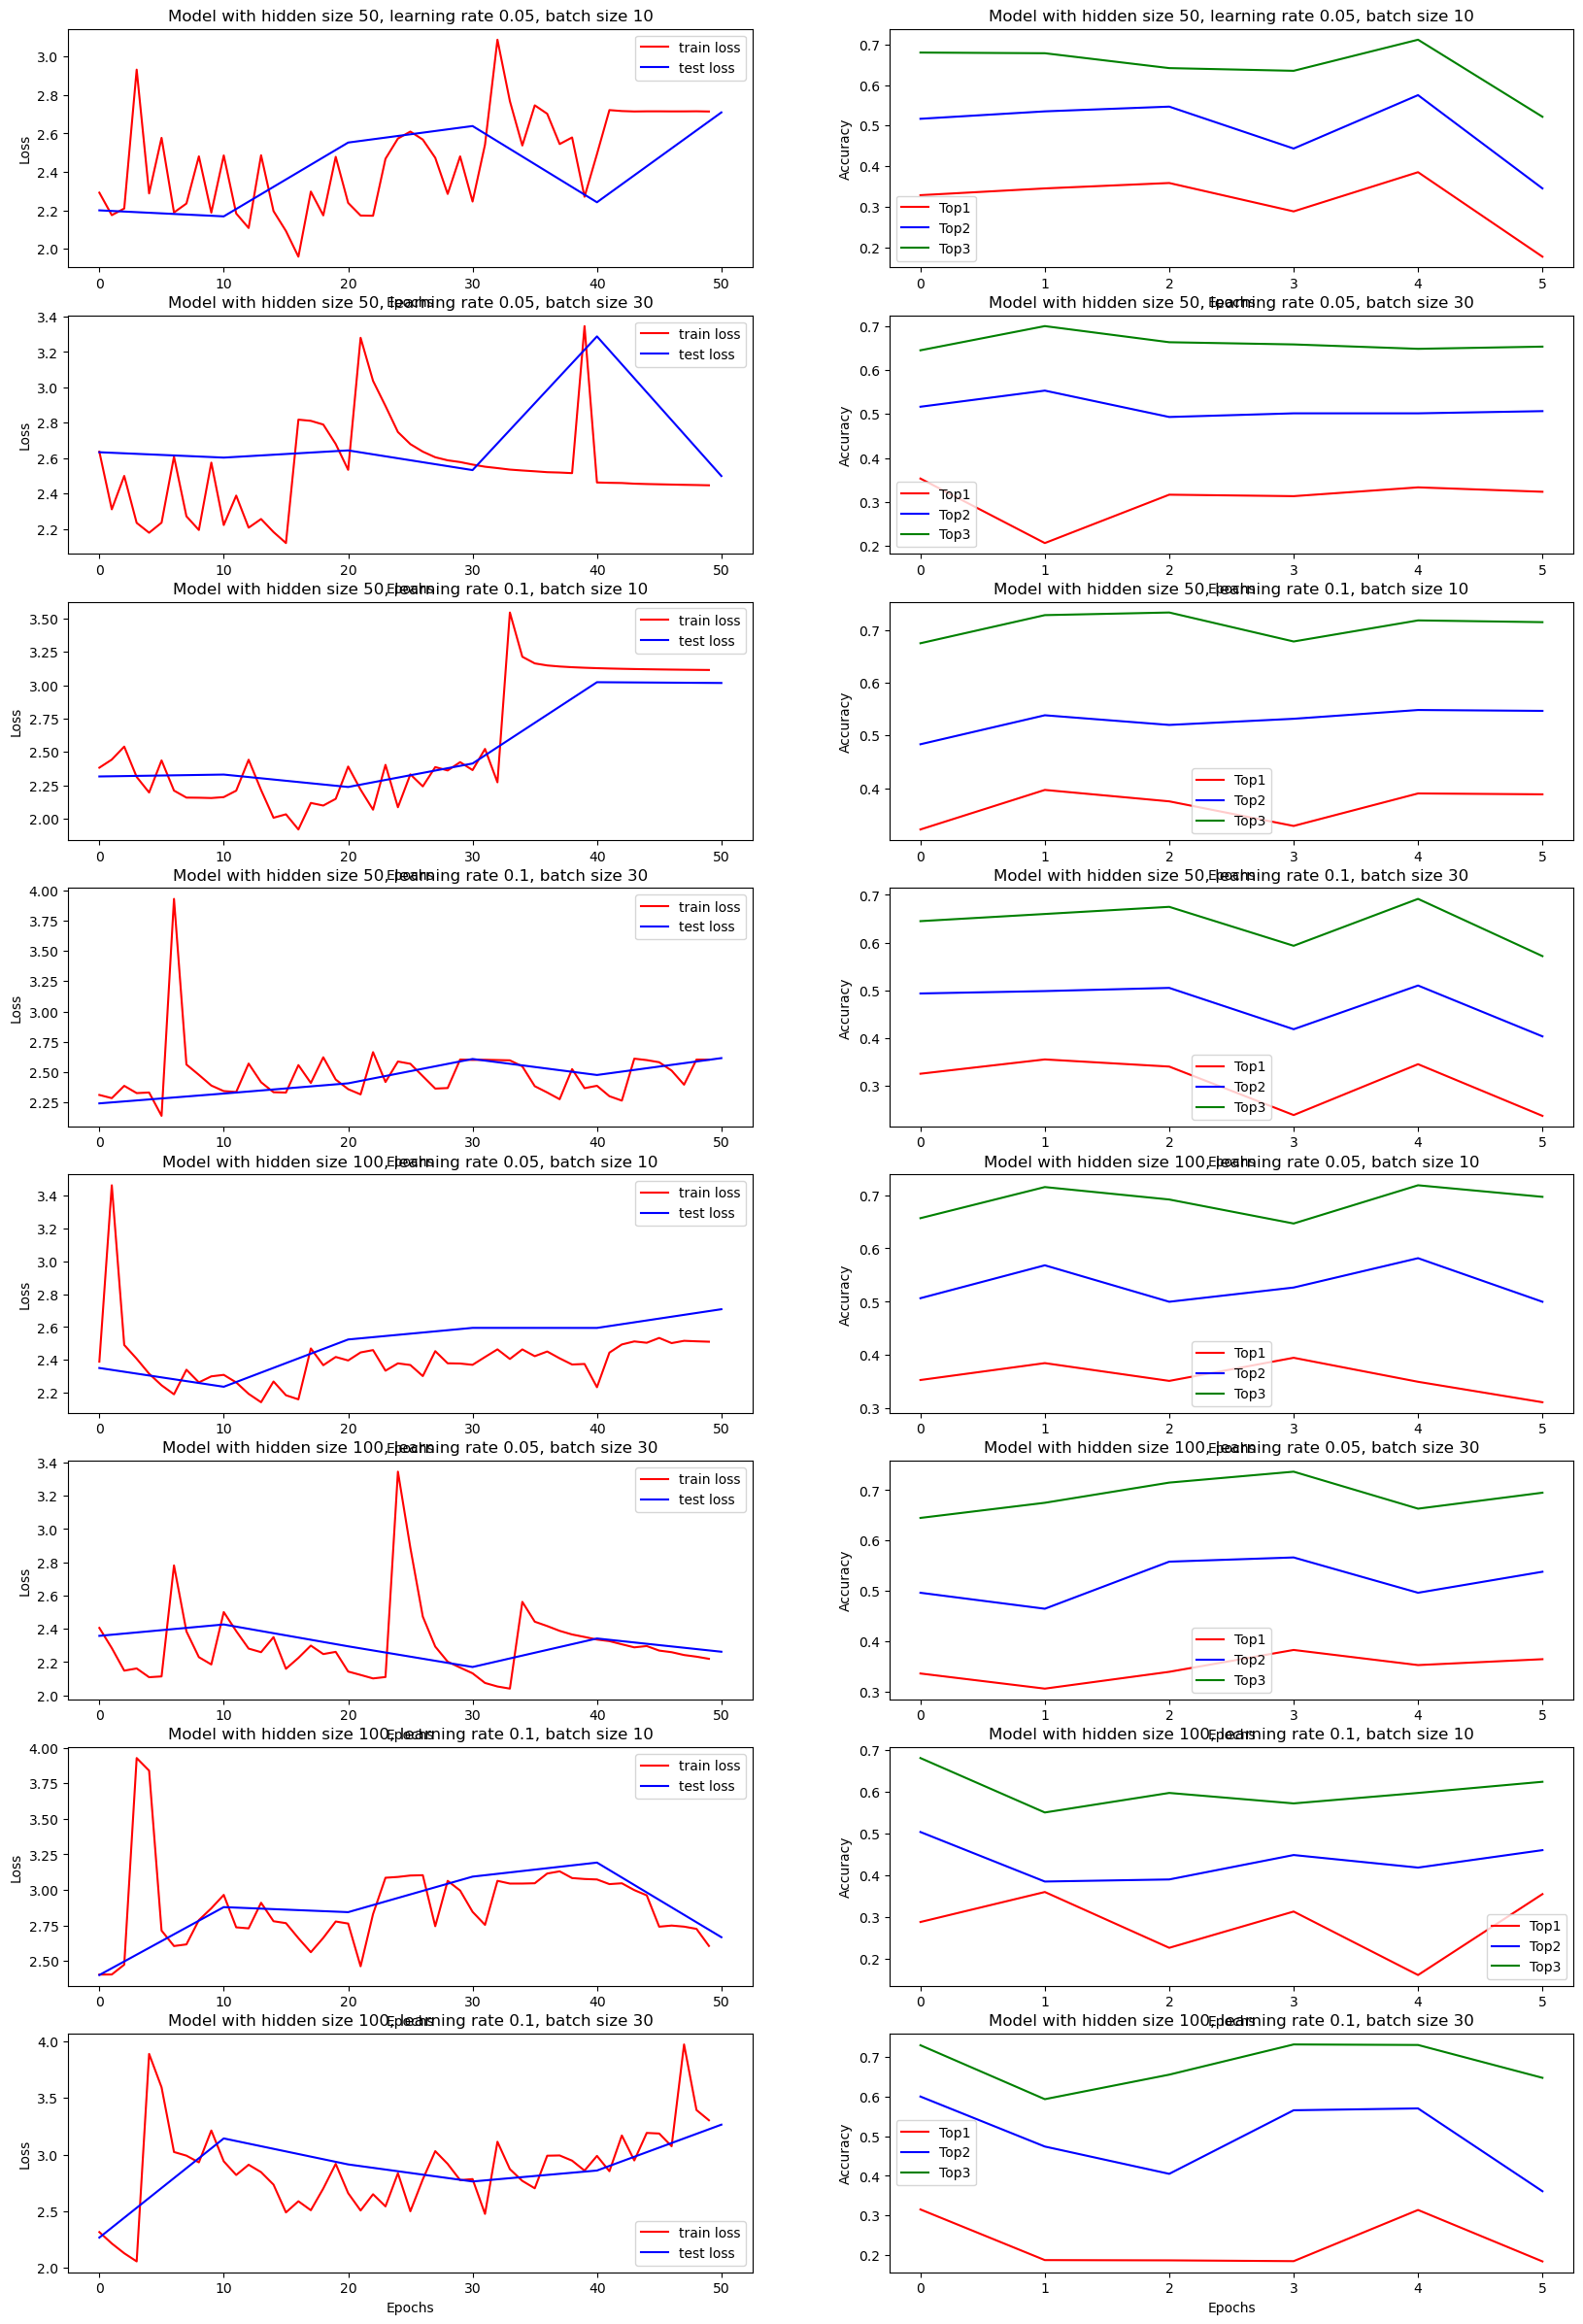

In [38]:
# plot the training and test losses for all models
fig, axs = plt.subplots(8, 2, figsize=(20, 30))

# first, the losses
for i, key in enumerate(modelspick.keys()):
    axs[i, 0].plot(modelspick[key].train_loss, color='red', label='train loss')
    axs[i, 0].plot(np.linspace(0, 50, 6), modelspick[key].test_loss, color='blue', label='test loss')
    axs[i, 0].set_title("Model with hidden size {}, learning rate {}, batch size {}".format(key[0], key[1], key[2]))
    axs[i, 0].legend()
    axs[i, 0].set_xlabel("Epochs")
    axs[i, 0].set_ylabel("Loss")
    
# second, the accuracies
for i, key in enumerate(modelspick.keys()):
    axs[i, 1].plot([acc[0] for acc in modelspick[key].testaccuracy], color='red', label='Top1')
    axs[i, 1].plot([acc[1] for acc in modelspick[key].testaccuracy], color='blue', label='Top2')
    axs[i, 1].plot([acc[2] for acc in modelspick[key].testaccuracy], color='green', label='Top3')
    axs[i, 1].set_title("Model with hidden size {}, learning rate {}, batch size {}".format(key[0], key[1], key[2]))
    axs[i, 1].legend()
    axs[i, 1].set_xlabel("Epochs")
    axs[i, 1].set_ylabel("Accuracy")
    
fig.savefig("RNNresults1.png")

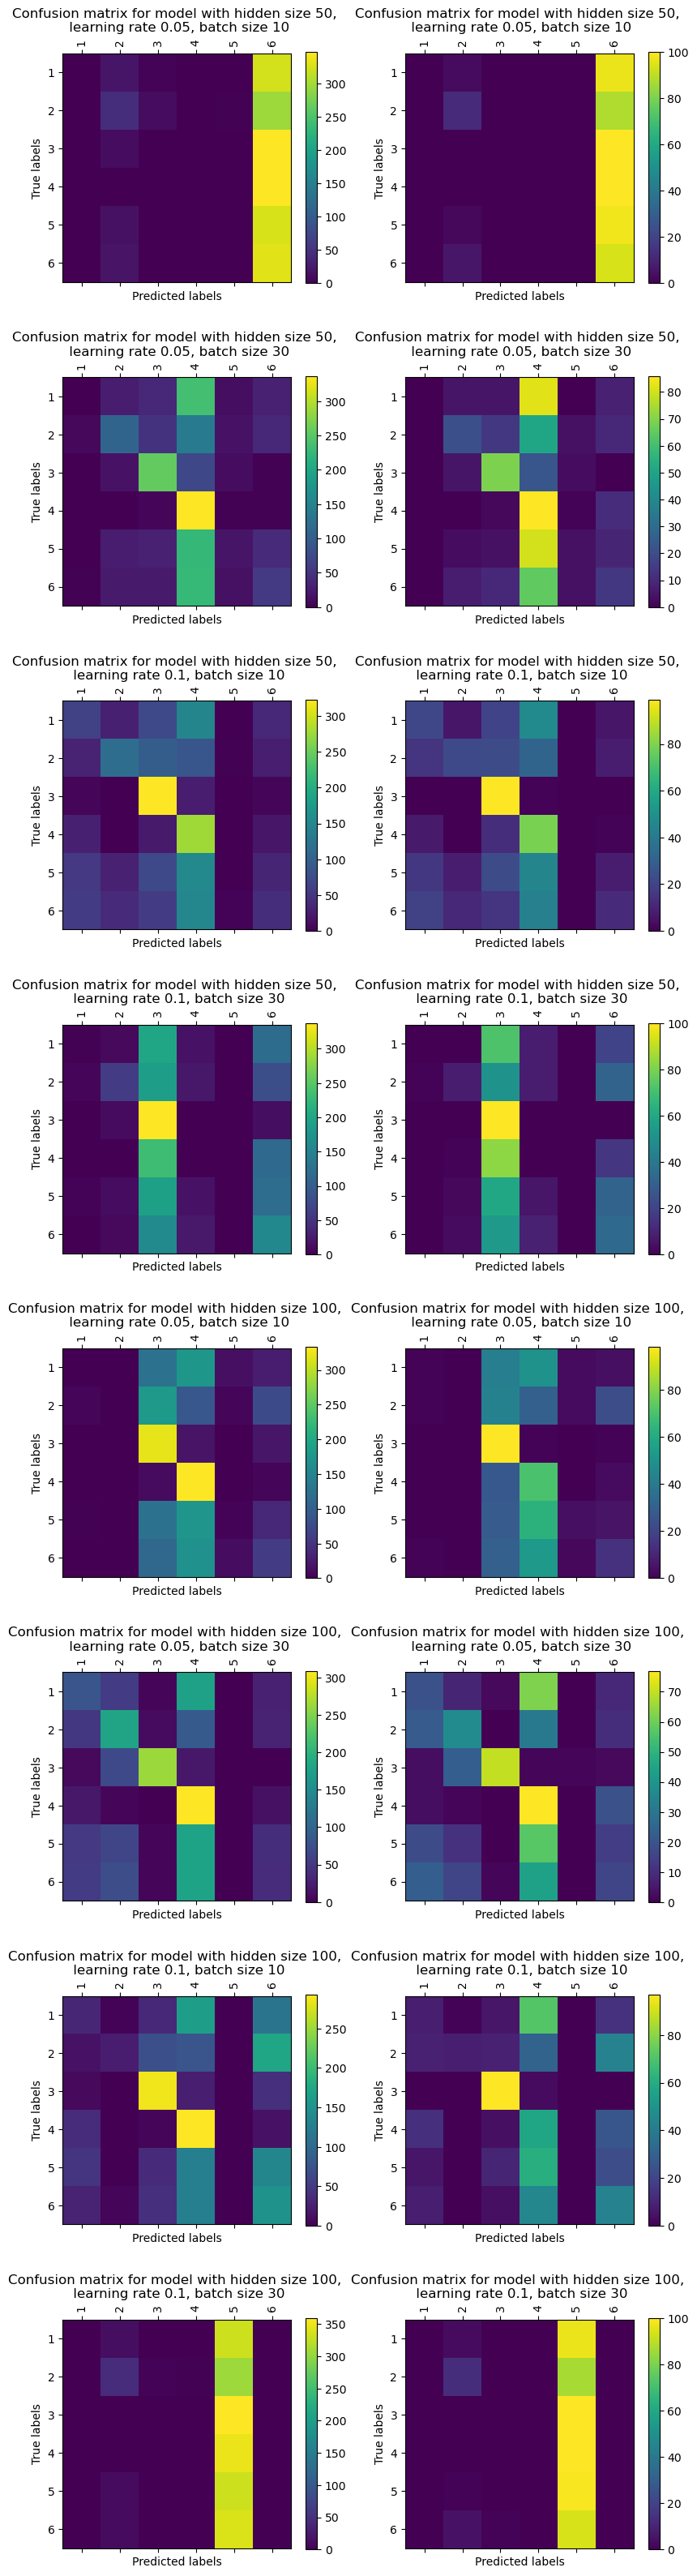

In [37]:
# using modelspick, predict the train and test data  
# and generate the confusion matrices
fig, axs = plt.subplots(8, 2, figsize=(10, 40))
for i, key in enumerate(modelspick.keys()):
    Y_pred = modelspick[key].forward_propagation(train_data_ext, predict=True)
    Y_pred = np.argmax(Y_pred, axis=0) + 1
    Y = np.argmax(train_labels, axis=0) + 1
    cm_train = confusion_matrix(Y, Y_pred)
    im = axs[i, 0].matshow(cm_train)
    axs[i, 0].set_title("Confusion matrix for model with hidden size {}, \n learning rate {}, batch size {}".format(key[0], key[1], key[2]))
    axs[i, 0].set_xlabel("Predicted labels")
    axs[i, 0].set_ylabel("True labels")
    axs[i, 0].set_xticks(np.arange(6))
    axs[i, 0].set_yticks(np.arange(6))
    axs[i, 0].set_xticklabels(np.arange(1, 7))
    axs[i, 0].set_yticklabels(np.arange(1, 7))
    axs[i, 0].tick_params(axis='x', rotation=90)
    
    cbar = fig.colorbar(im, ax=axs[i, 0])


# Loop through models and generate confusion matrices for test data
for i, key in enumerate(modelspick.keys()):
    Y_pred_test = modelspick[key].forward_propagation(test_data_ext, predict=True)
    Y_pred_test = np.argmax(Y_pred_test, axis=0) + 1
    Y_test = np.argmax(test_labels, axis=0) + 1
    cm_test = confusion_matrix(Y_test, Y_pred_test)
    im = axs[i, 1].matshow(cm_test)
    axs[i, 1].set_title("Confusion matrix for model with hidden size {}, \n learning rate {}, batch size {}".format(key[0], key[1], key[2]))
    axs[i, 1].set_xlabel("Predicted labels")
    axs[i, 1].set_ylabel("True labels")
    axs[i, 1].set_xticks(np.arange(6))
    axs[i, 1].set_yticks(np.arange(6))
    axs[i, 1].set_xticklabels(np.arange(1, 7))
    axs[i, 1].set_yticklabels(np.arange(1, 7))
    axs[i, 1].tick_params(axis='x', rotation=90)
    cbar = fig.colorbar(im, ax=axs[i, 1])

    
    
plt.subplots_adjust(hspace=0.4)  # Increase the bottom margin

# save the figure
fig.savefig("RNN_confusion_matrices.png")

In [30]:
# Hence, we try the best performing 
dA0RNN = RNN(input_size = input_size, hidden_size = hidden_size[1], output_size = output_size, init = "Xavier")
dA0RNN.train(train_data_ext, train_labels, test_data_ext, test_labels, learning_rate = 0.009, batch_size = batch_size[1], num_epochs = 60)

(30,)
blank loss: 4.433468279877861
blank accuracy: [[0.10066667]
 [0.23033333]
 [0.48033333]]
Epoch 1, Train Loss: 2.5005216112718274, Train Accuracy Top1: [0.32866667]
Epoch 1: train loss = 2.5005216112718274, test loss = 2.471533743746467, train accuracy = [[0.32866667]
 [0.52      ]
 [0.66833333]], test accuracy = [[0.31833333]
 [0.46333333]
 [0.62833333]]
Epoch 2, Train Loss: 2.2256874408417917, Train Accuracy Top1: [0.443]
Epoch 3, Train Loss: 2.191702796066605, Train Accuracy Top1: [0.42733333]
Epoch 4, Train Loss: 2.093262468037655, Train Accuracy Top1: [0.484]
Epoch 5, Train Loss: 2.0762302849676497, Train Accuracy Top1: [0.47366667]
Epoch 6, Train Loss: 2.635635871480563, Train Accuracy Top1: [0.374]
Epoch 7, Train Loss: 2.445087115519754, Train Accuracy Top1: [0.40466667]
Epoch 8, Train Loss: 2.2698897937198397, Train Accuracy Top1: [0.435]
Epoch 9, Train Loss: 2.185589832431309, Train Accuracy Top1: [0.453]
Epoch 10, Train Loss: 2.1770100934382097, Train Accuracy Top1: [0.4

Looking at these results, none of these networks seem to be doing so well, so we change the initialization and try some of the most promising networks again. Moreover, it seems to be the case that both learning rates are high enough to render the learning chaotic, hence, now we reduce the learning rate, and in general, batch size = 30 seems to be more stable. Hence, we try two new networks, with differrent hidden sizes, batch = 30, and learning rate = 0.01

In [18]:
# generate the networks described in the cell above in the dictionary Xaviermodels, and train them on train_data_ext
# both networks have learning rate = 0.01, batch size = 30, and 50 epochs, only difference is the hidden dim  50 and 100
Xaviermodels = {(hidden_size[i], 0.01, batch_size[1]): RNN(input_size, hidden_size[i], output_size, init = "Xavier") for i in range(len(hidden_size))}
for model in Xaviermodels.values():
    model.train(train_data_ext, train_labels, test_data_ext, test_labels, learning_rate = 0.01, batch_size = batch_size[1], num_epochs = 50)


(30,)
blank loss: 4.198402164059557
blank accuracy: [[0.191     ]
 [0.39      ]
 [0.56766667]]
Epoch 1, Train Loss: 2.510638107437011, Train Accuracy Top1: [0.40533333]
Epoch 1: train loss = 2.510638107437011, test loss = 2.509619432820467, train accuracy = [[0.40533333]
 [0.57266667]
 [0.72366667]], test accuracy = [[0.35      ]
 [0.47833333]
 [0.67833333]]
Epoch 2, Train Loss: 2.3307382497102402, Train Accuracy Top1: [0.412]
Epoch 3, Train Loss: 2.289944818287226, Train Accuracy Top1: [0.41466667]
Epoch 4, Train Loss: 2.2170853021569634, Train Accuracy Top1: [0.439]
Epoch 5, Train Loss: 2.1850608662199367, Train Accuracy Top1: [0.44766667]
Epoch 6, Train Loss: 2.1544119035148013, Train Accuracy Top1: [0.46866667]
Epoch 7, Train Loss: 2.101489203216972, Train Accuracy Top1: [0.476]
Epoch 8, Train Loss: 2.051637533941897, Train Accuracy Top1: [0.49733333]
Epoch 9, Train Loss: 1.9899220309315053, Train Accuracy Top1: [0.523]
Epoch 10, Train Loss: 2.134656843034288, Train Accuracy Top1: 

In [24]:
# add a new model with hidden size 50, learning rate 0.01, batch size 10, 50 epochs, and Xavier initialization to Xaviermodels
Xaviermodels[(50, 0.01, 10)] = RNN(input_size, 50, output_size, init = "Xavier")
Xaviermodels[(50, 0.01, 10)].train(train_data_ext, train_labels, test_data_ext, test_labels, learning_rate = 0.01, batch_size = 10, num_epochs = 50)

(10,)
blank loss: 4.396192089580272
blank accuracy: [[0.19733333]
 [0.41066667]
 [0.578     ]]
Epoch 1, Train Loss: 2.245557537518028, Train Accuracy Top1: [0.39966667]
Epoch 1: train loss = 2.245557537518028, test loss = 2.2125598433928597, train accuracy = [[0.39966667]
 [0.59333333]
 [0.75833333]], test accuracy = [[0.36      ]
 [0.53333333]
 [0.71666667]]
Epoch 2, Train Loss: 2.9595270660207427, Train Accuracy Top1: [0.231]
Epoch 3, Train Loss: 2.1741339343723562, Train Accuracy Top1: [0.47766667]
Epoch 4, Train Loss: 1.9813720891715723, Train Accuracy Top1: [0.53433333]
Epoch 5, Train Loss: 2.368635551287011, Train Accuracy Top1: [0.40533333]
Epoch 6, Train Loss: 2.1498567763475336, Train Accuracy Top1: [0.455]
Epoch 7, Train Loss: 2.0567259372295177, Train Accuracy Top1: [0.502]
Epoch 8, Train Loss: 2.752863679084186, Train Accuracy Top1: [0.36133333]
Epoch 9, Train Loss: 2.3687618383959324, Train Accuracy Top1: [0.38133333]
Epoch 10, Train Loss: 2.134359557768307, Train Accuracy

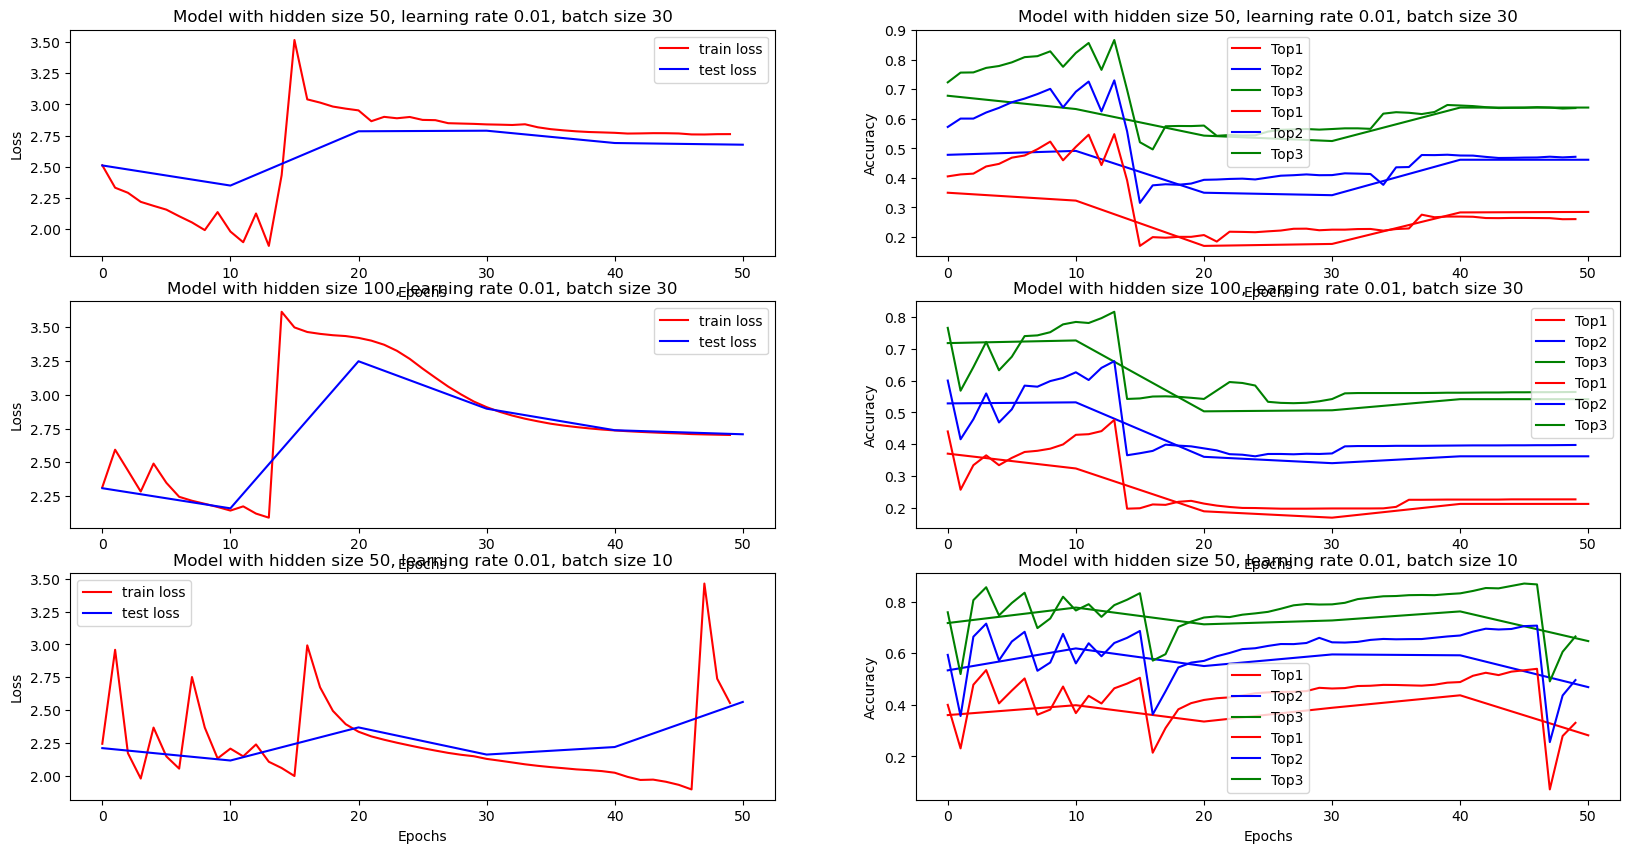

In [38]:
# plot the metrics for Xaviermodels
# plot the training and test losses for all models
fig, axs = plt.subplots(3, 2, figsize=(20, 10))

# first, the losses
for i, key in enumerate(Xaviermodels.keys()):
    axs[i, 0].plot(Xaviermodels[key].train_loss, color='red', label='train loss')
    axs[i, 0].plot(np.linspace(0, 50, 6), Xaviermodels[key].test_loss, color='blue', label='test loss')
    axs[i, 0].set_title("Model with hidden size {}, learning rate {}, batch size {}".format(key[0], key[1], key[2]))
    axs[i, 0].legend()
    axs[i, 0].set_xlabel("Epochs")
    axs[i, 0].set_ylabel("Loss")
    
# second, the accuracies
for i, key in enumerate(Xaviermodels.keys()):
    axs[i, 1].plot(np.linspace(0, 50, 6), [acc[0] for acc in Xaviermodels[key].testaccuracy], color='red', label='Top1')
    axs[i, 1].plot(np.linspace(0, 50, 6), [acc[1] for acc in Xaviermodels[key].testaccuracy], color='blue', label='Top2')
    axs[i, 1].plot(np.linspace(0, 50, 6), [acc[2] for acc in Xaviermodels[key].testaccuracy], color='green', label='Top3')
    axs[i, 1].plot([acc[0] for acc in Xaviermodels[key].trainaccuracy], color='red', label='Top1')
    axs[i, 1].plot([acc[1] for acc in Xaviermodels[key].trainaccuracy], color='blue', label='Top2')
    axs[i, 1].plot([acc[2] for acc in Xaviermodels[key].trainaccuracy], color='green', label='Top3')
    axs[i, 1].set_title("Model with hidden size {}, learning rate {}, batch size {}".format(key[0], key[1], key[2]))
    axs[i, 1].legend()
    axs[i, 1].set_xlabel("Epochs")
    axs[i, 1].set_ylabel("Accuracy")
    
fig.savefig("RNNresultsXavier.png")

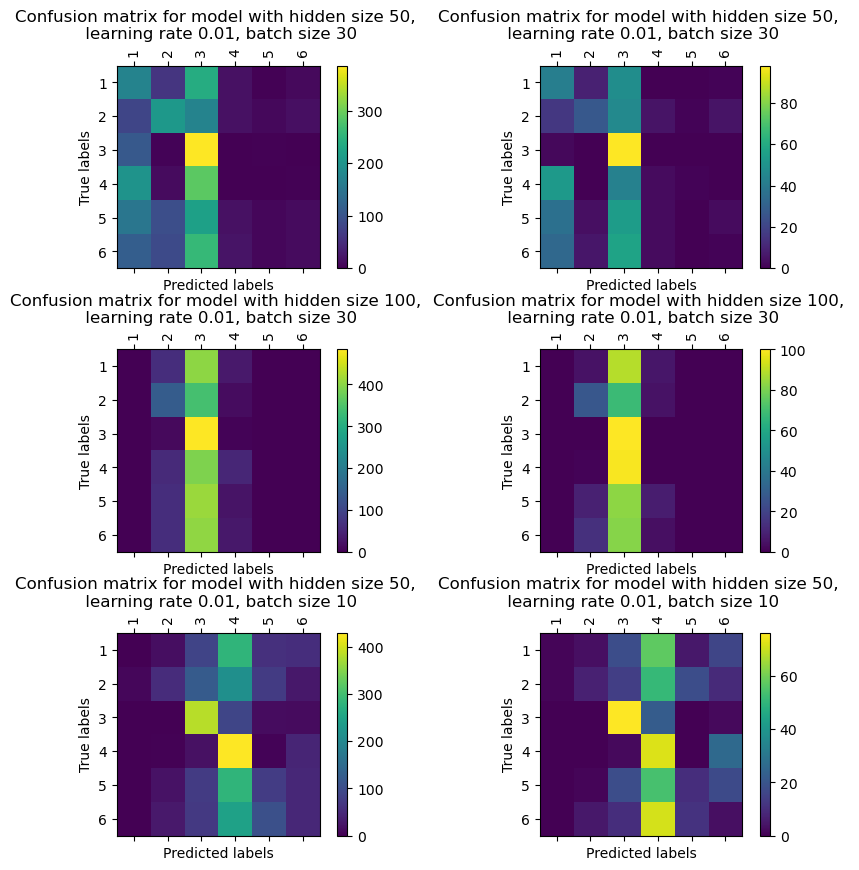

In [30]:
# plot confusion matrices for Xaviermodels on the train and test set
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

for i, key in enumerate(Xaviermodels.keys()):
    Y_pred = Xaviermodels[key].forward_propagation(train_data_ext, predict=True)
    Y_pred = np.argmax(Y_pred, axis=0) + 1
    Y = np.argmax(train_labels, axis=0) + 1
    cm_train = confusion_matrix(Y, Y_pred)
    im = axs[i, 0].matshow(cm_train)
    axs[i, 0].set_title("Confusion matrix for model with hidden size {}, \n learning rate {}, batch size {}".format(key[0], key[1], key[2]))
    axs[i, 0].set_xlabel("Predicted labels")
    axs[i, 0].set_ylabel("True labels")
    axs[i, 0].set_xticks(np.arange(6))
    axs[i, 0].set_yticks(np.arange(6))
    axs[i, 0].set_xticklabels(np.arange(1, 7))
    axs[i, 0].set_yticklabels(np.arange(1, 7))
    axs[i, 0].tick_params(axis='x', rotation=90)
    
    cbar = fig.colorbar(im, ax=axs[i, 0])
    
for i, key in enumerate(Xaviermodels.keys()):
    Y_pred_test = Xaviermodels[key].forward_propagation(test_data_ext, predict=True)
    Y_pred_test = np.argmax(Y_pred_test, axis=0) + 1
    Y_test = np.argmax(test_labels, axis=0) + 1
    cm_test = confusion_matrix(Y_test, Y_pred_test)
    im = axs[i, 1].matshow(cm_test)
    axs[i, 1].set_title("Confusion matrix for model with hidden size {}, \n learning rate {}, batch size {}".format(key[0], key[1], key[2]))
    axs[i, 1].set_xlabel("Predicted labels")
    axs[i, 1].set_ylabel("True labels")
    axs[i, 1].set_xticks(np.arange(6))
    axs[i, 1].set_yticks(np.arange(6))
    axs[i, 1].set_xticklabels(np.arange(1, 7))
    axs[i, 1].set_yticklabels(np.arange(1, 7))
    axs[i, 1].tick_params(axis='x', rotation=90)
    
    cbar = fig.colorbar(im, ax=axs[i, 1])


plt.subplots_adjust(hspace=0.4)  # Increase the bottom margin
fig.savefig("RNN_confusion_matrices_Xavier.png")

In [36]:
# separate the training data into validation and training sets
random_indices = np.random.permutation(train_data_ext.shape[1])
val_data_ext = train_data_ext[:, random_indices[0:300], :]
val_labels = train_labels[:, random_indices[0:300]]
train_data_ext = train_data_ext[:, random_indices[300:], :]
train_labels = train_labels[:, random_indices[300:]]

best_configs = [(50, 0.01, 30, "Xavier"), (50, 0.01, 10, "Xavier")]

earlystopmodels = {config : RNN(input_size, config[0], output_size, init = config[3]) for config in best_configs}

for config in best_configs:
    earlystopmodels[config].train_es(train_data_ext, train_labels, val_data_ext, val_labels, test_data_ext, test_labels, learning_rate = config[1], batch_size = config[2], num_epochs = 50, patience = 10)

(30,)
blank loss: 4.346880333533628
blank accuracy: [[0.24190476]
 [0.37190476]
 [0.5752381 ]]
Epoch 1, Train Loss: 2.541362677499199, Train Accuracy Top1: [0.3047619]
Epoch 1, Validation Loss: 2.5504166461796474, Validation Accuracy Top1: [0.29]
Epoch 1: train loss = 2.541362677499199, test loss = 2.5164580639521548, train accuracy = [[0.3047619 ]
 [0.48047619]
 [0.69047619]], test accuracy = [[0.31833333]
 [0.475     ]
 [0.64333333]]
Epoch 2, Train Loss: 2.3606543311595667, Train Accuracy Top1: [0.38333333]
Epoch 2, Validation Loss: 2.3911819330302007, Validation Accuracy Top1: [0.39]
Epoch 3, Train Loss: 2.2986735428466725, Train Accuracy Top1: [0.39571429]
Epoch 3, Validation Loss: 2.3447876371285727, Validation Accuracy Top1: [0.38333333]
Epoch 4, Train Loss: 2.2634936531342627, Train Accuracy Top1: [0.40952381]
Epoch 4, Validation Loss: 2.312667641714479, Validation Accuracy Top1: [0.40333333]
Epoch 5, Train Loss: 2.24850964846426, Train Accuracy Top1: [0.42]
Epoch 5, Validation 

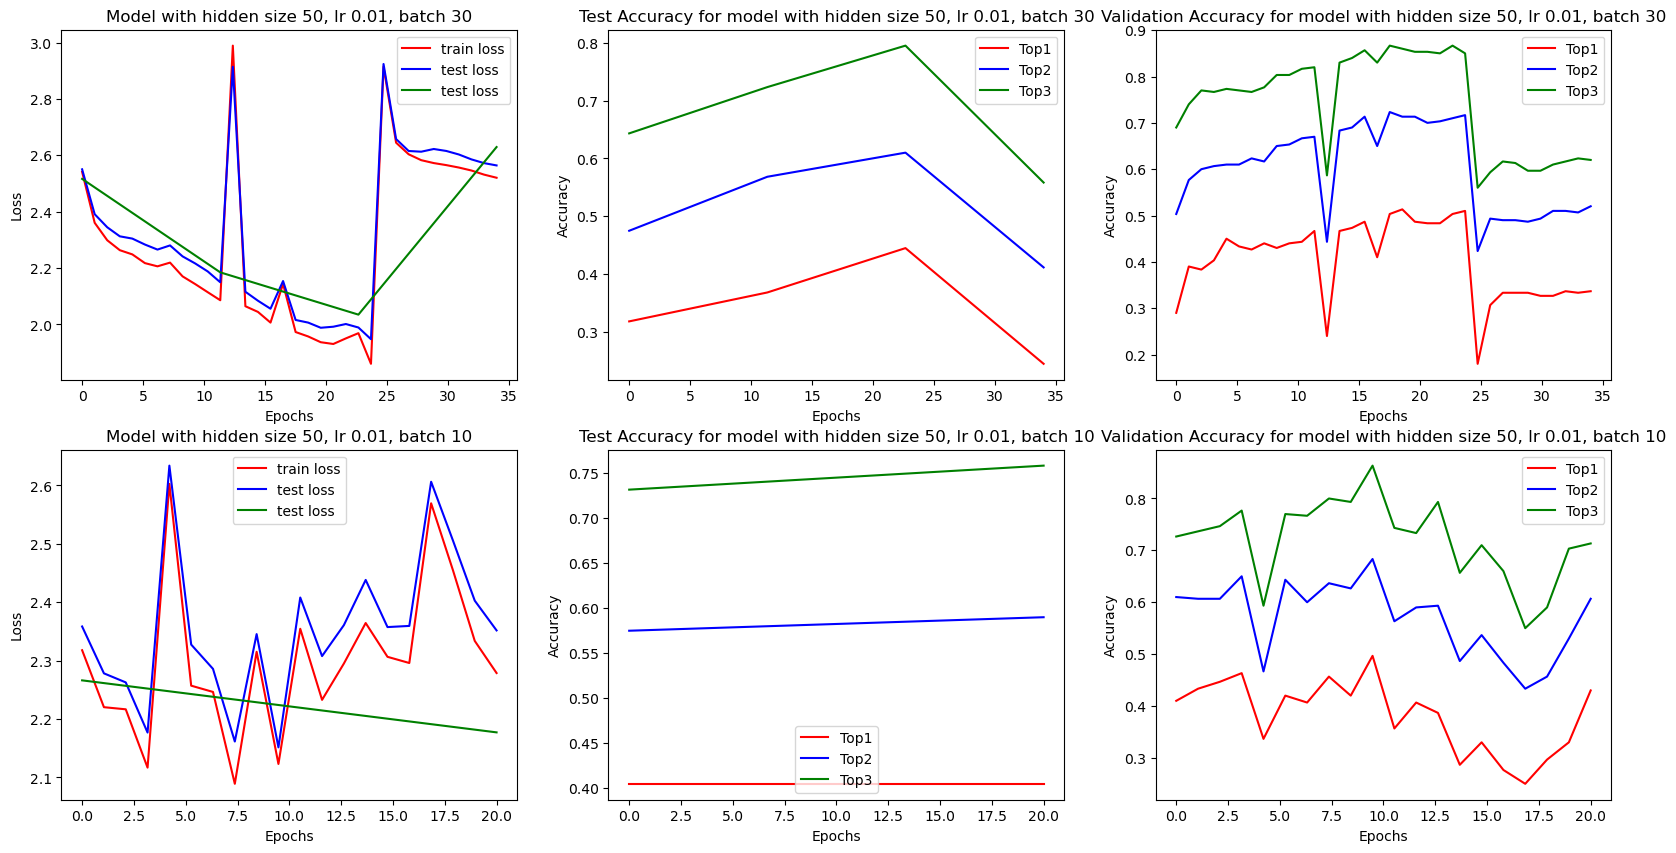

In [46]:
# plot the metrics for earlystopmodels
# plot the validation and test losses for all models
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
esepoch = [34 , 20]

# first, the losses
for i, key in enumerate(earlystopmodels.keys()):
    axs[i, 0].plot(np.linspace(0, esepoch[i], len(earlystopmodels[key].train_loss)), earlystopmodels[key].train_loss, color='red', label='train loss')
    axs[i, 0].plot(np.linspace(0, esepoch[i], len(earlystopmodels[key].val_loss)), earlystopmodels[key].val_loss, color='blue', label='test loss')
    axs[i, 0].plot(np.linspace(0, esepoch[i], len(earlystopmodels[key].test_loss)), earlystopmodels[key].test_loss, color='green', label='test loss')
    axs[i, 0].set_title("Model with hidden size {}, lr {}, batch {}".format(key[0], key[1], key[2]))
    axs[i, 0].legend()
    axs[i, 0].set_xlabel("Epochs")
    axs[i, 0].set_ylabel("Loss")
    
# second, the accuracies
for i, key in enumerate(earlystopmodels.keys()):
    axs[i, 1].plot(np.linspace(0, esepoch[i], len([acc[0] for acc in earlystopmodels[key].testaccuracy])), [acc[0] for acc in earlystopmodels[key].testaccuracy], color='red', label='Top1')
    axs[i, 1].plot(np.linspace(0, esepoch[i], len([acc[1] for acc in earlystopmodels[key].testaccuracy])), [acc[1] for acc in earlystopmodels[key].testaccuracy], color='blue', label='Top2')
    axs[i, 1].plot(np.linspace(0, esepoch[i], len([acc[2] for acc in earlystopmodels[key].testaccuracy])), [acc[2] for acc in earlystopmodels[key].testaccuracy], color='green', label='Top3')
    axs[i, 1].set_title("Test Accuracy for model with hidden size {}, lr {}, batch {}".format(key[0], key[1], key[2]))
    axs[i, 1].legend()
    axs[i, 1].set_xlabel("Epochs")
    axs[i, 1].set_ylabel("Accuracy")
    
for i, key in enumerate(earlystopmodels.keys()):   
    axs[i, 2].plot(np.linspace(0, esepoch[i], len([acc[0] for acc in earlystopmodels[key].valaccuracy])), [acc[0] for acc in earlystopmodels[key].valaccuracy], color='red', label='Top1')
    axs[i, 2].plot(np.linspace(0, esepoch[i], len([acc[1] for acc in earlystopmodels[key].valaccuracy])), [acc[1] for acc in earlystopmodels[key].valaccuracy], color='blue', label='Top2')
    axs[i, 2].plot(np.linspace(0, esepoch[i], len([acc[2] for acc in earlystopmodels[key].valaccuracy])), [acc[2] for acc in earlystopmodels[key].valaccuracy], color='green', label='Top3')
    axs[i, 2].set_title("Validation Accuracy for model with hidden size {}, lr {}, batch {}".format(key[0], key[1], key[2]))
    axs[i, 2].legend()
    axs[i, 2].set_xlabel("Epochs")
    axs[i, 2].set_ylabel("Accuracy")

plt.subplots_adjust(hspace=0.2)  # Increase the bottom margin

fig.savefig("RNNresultsES.png")

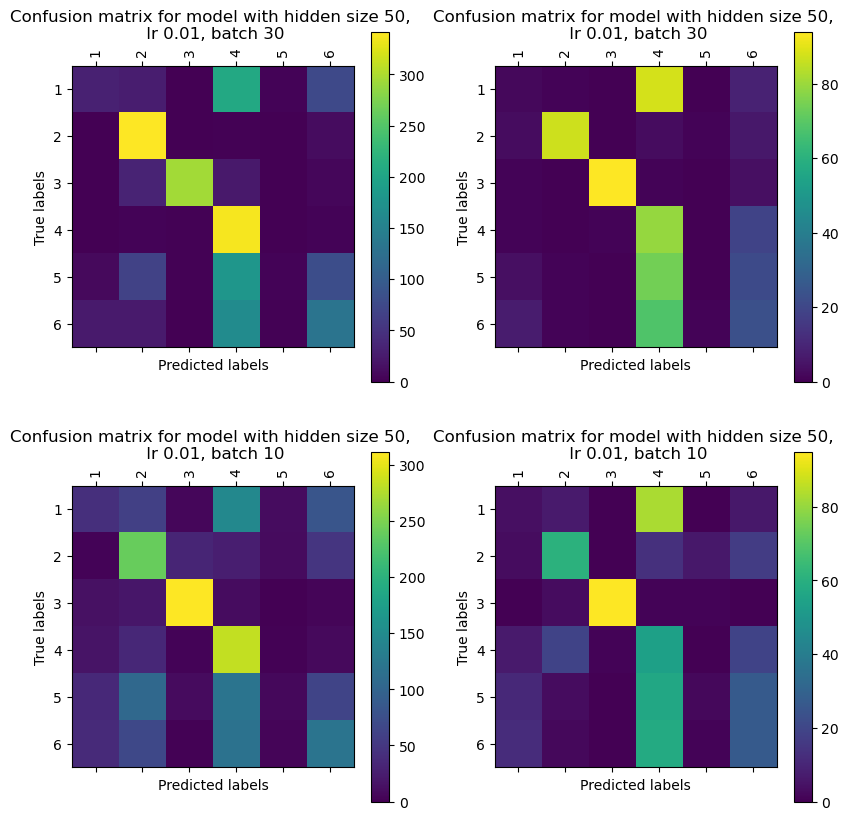

In [48]:
# plot confusion matrices for earlystopmodels on the train and test set
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, key in enumerate(earlystopmodels.keys()):
    Y_pred = earlystopmodels[key].forward_propagation(train_data_ext, predict=True)
    Y_pred = np.argmax(Y_pred, axis=0) + 1
    Y = np.argmax(train_labels, axis=0) + 1
    cm_train = confusion_matrix(Y, Y_pred)
    im = axs[i, 0].matshow(cm_train)
    axs[i, 0].set_title("Confusion matrix for model with hidden size {}, \n lr {}, batch {}".format(key[0], key[1], key[2]))
    axs[i, 0].set_xlabel("Predicted labels")
    axs[i, 0].set_ylabel("True labels")
    axs[i, 0].set_xticks(np.arange(6))
    axs[i, 0].set_yticks(np.arange(6))
    axs[i, 0].set_xticklabels(np.arange(1, 7))
    axs[i, 0].set_yticklabels(np.arange(1, 7))
    axs[i, 0].tick_params(axis='x', rotation=90)
    
    cbar = fig.colorbar(im, ax=axs[i, 0])
    
for i, key in enumerate(earlystopmodels.keys()):
    Y_pred_test = earlystopmodels[key].forward_propagation(test_data_ext, predict=True)
    Y_pred_test = np.argmax(Y_pred_test, axis=0) + 1
    Y_test = np.argmax(test_labels, axis=0) + 1
    cm_test = confusion_matrix(Y_test, Y_pred_test)
    im = axs[i, 1].matshow(cm_test)
    axs[i, 1].set_title("Confusion matrix for model with hidden size {}, \n lr {}, batch {}".format(key[0], key[1], key[2]))
    axs[i, 1].set_xlabel("Predicted labels")
    axs[i, 1].set_ylabel("True labels")
    axs[i, 1].set_xticks(np.arange(6))
    axs[i, 1].set_yticks(np.arange(6))
    axs[i, 1].set_xticklabels(np.arange(1, 7))
    axs[i, 1].set_yticklabels(np.arange(1, 7))
    axs[i, 1].tick_params(axis='x', rotation=90)
    
    cbar = fig.colorbar(im, ax=axs[i, 1])


plt.subplots_adjust(hspace=0.2)  # Increase the bottom margin
fig.savefig("RNN_confusion_matrices_ES.png")

In [49]:
# calculate the test loss and accuracy on the final states of the networks in earlystopmodels
ESmodels_accuracies = {key : earlystopmodels[key].accuracy(test_labels, earlystopmodels[key].forward_propagation(test_data_ext, predict=True)) for key in earlystopmodels.keys()}
print(ESmodels_accuracies)

{(50, 0.01, 30, 'Xavier'): array([[0.475     ],
       [0.64833333],
       [0.81833333]]), (50, 0.01, 10, 'Xavier'): array([[0.405     ],
       [0.59      ],
       [0.75833333]])}
